In [1]:
import pandas as pd
import numpy as np
import glob
import os
from pathlib import Path
from PIL import Image, ExifTags

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, accuracy_score
import scipy

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.layers import Activation, Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LambdaCallback

#salmon-scales
#from train_util import read_images, load_xy, get_checkpoint_tensorboard, create_model_grayscale, get_fresh_weights, base_output, dense1_linear_output, train_validate_test_split


In [3]:
!pip install plotly --user
!pip install torch --user
!pip install loguru --user
!pip install timm --user #PyTorch Image Models
!pip install albumentations  --user #augmentation
!pip install colorama --user #color terminal

In [2]:
import os
import gc
import copy
import time
import random

import numpy as np
import pandas as pd
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

from tqdm import tqdm
from collections import defaultdict

from loguru import logger

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from colorama import Fore
b_ = Fore.BLUE

from train_val_test_split import train_validate_test_split

### Train Configuration

In [36]:
# Source: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/efficientnet.py
# tf_efficientnetv2_s_in21k - input_size=(3, 300, 300), test_input_size=(3, 384, 384)
# tf_efficientnetv2_m_in21k - input_size=(3, 384, 384), test_input_size=(3, 480, 480)
# tf_efficientnetv2_l_in21k - input_size=(3, 384, 384), test_input_size=(3, 480, 480)
# tf_efficientnetv2_xl_in21k -input_size=(3, 384, 384), test_input_size=(3, 512, 512)

class CONFIG:
    seed = 42
    model_name = 'tf_efficientnetv2_m_in21k' 
    train_batch_size = 8
    valid_batch_size = 8
    img_size = 384
    val_img_size = 480
    learning_rate = 1e-6
    min_lr = 1e-8
    weight_decay = 1e-8
    T_max = 10
    scheduler = 'CosineAnnealingLR'
    n_accumulate = 1
    n_fold = 10 #5
    target_size = 1
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    debugging = False
    which_exposure = "min"
    CHANNELS = "channels_first"
    KERAS_TRAIN_TEST_SEED = 2021
    ROOTDIR = "./EFFNetV2_m/"
    CUDA_VISIBLE_DEVICE = "0"
    #tensorboard_path = 'tensorboard_test2'
    #checkpoint_path = 'checkpoints_test2/cod_oto_efficientnetBBB.{epoch:03d}-{val_loss:.2f}.hdf5'
    input_shape = (3, img_size, img_size)
    test_size = 0.005 #0.15
    test_split_seed = 8
    steps_per_epoch = 1600
    epochs = 25 #50
    early_stopping_patience = 14
    reduceLROnPlateau_factor = 0.2
    reduceLROnPlateau_patience = 7
    base_dir = '/gpfs/gpfs0/deep/data/Savannah_Professional_Practice2021_08_12_2021/CodOtholiths-MachineLearning/Savannah_Professional_Practice'
    
    
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG.seed)    

In [4]:
import json

config_dict = CONFIG.__dict__
config_dict = dict(config_dict)
config_dict.pop('device', None)
config_dict.pop('__dict__', None)
config_dict.pop('__weakref__', None)
config_dict.pop('__doc__', None)

with open(CONFIG.ROOTDIR+'config.json', 'w', encoding='utf-8') as f:
    json.dump(config_dict, f, ensure_ascii=False, indent=4)

### Read files to Pandas

In [5]:
from utils.read_jpg_cods import read_jpg_cods
from utils.train_val_test_split import *
from utils.train_test_split import *

CONFIG.debugging = False
df = read_jpg_cods( CONFIG ) #5316 #5110 #5150
#5110 images, after updating folder 2015: len age:5153 



error_count:226
add_count:5150


In [6]:
CONFIG.img_size = CONFIG.val_img_size
df_test = read_jpg_cods( CONFIG ) 

error_count:226
add_count:5150


### Train/Test split

In [40]:
print("len age:"+str( len(df.age) ) ) #len age:5090, error_count:205
train_imgs, train_age, test_imgs, test_age, test_path = train_test_split(df, CONFIG, test_size=CONFIG.test_size, a_seed=CONFIG.test_split_seed)
test_path.to_csv( CONFIG.ROOTDIR+"test_set_files.csv", index=False)
train_imgs2, train_age2, test_imgs2, test_age2, test_path2 = train_test_split(df_test, CONFIG, test_size=CONFIG.test_size, a_seed=CONFIG.test_split_seed)

print(np.any(test_path2==test_path))
print(np.any(test_age==test_age2))
test_imgs = test_imgs2


del train_imgs2
del test_imgs2
del train_age2
del test_age2
print(test_imgs.shape)

#df1 = pd.DataFrame(list(zip(train_imgs, train_age)), columns=['image', 'age'])

print(train_imgs.shape)
print(len(train_age))
print(test_imgs.shape)
print(len(test_age))
print(len(train_age)+len(test_age))
print(len(df))
#print(len(df1))

len age:5150
True
True
(25, 3, 480, 480)
(5125, 3, 384, 384)
5125
(25, 3, 480, 480)
25
5150
5150


In [32]:

print(np.any(test_path2==test_path))
print(np.any(test_age==test_age2))

True


NameError: name 'test_age2' is not defined

In [14]:
print( train_imgs.shape )
print( type(train_imgs ))
print( type(train_age ))

a_seed = CONFIG.KERAS_TRAIN_TEST_SEED #2021
numberOfFolds = CONFIG.n_fold #5
kfold = StratifiedKFold(n_splits=numberOfFolds, random_state=a_seed, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_imgs, train_age.tolist())):
    train_imgs_new = train_imgs[train_idx]
    train_age_new = train_age[train_idx]
    val_imgs_new = train_imgs[val_idx]
    val_age_new = train_age[val_idx]
    
    print( train_imgs_new.shape )
    print( train_age_new.shape )
    print( type( train_imgs_new ))
    print( type( train_age_new ))
    print( val_imgs_new.shape )
    print( val_age_new.shape )
    
    #print(train_imgs_new[0:5])
    print("#########################")
    #print(val_imgs_new[0:5])
    
    train_dataset = codDataset(train_imgs_new, train_age_new)
    valid_dataset = codDataset(val_imgs_new, val_age_new)

    train_loader = DataLoader(train_dataset, batch_size=CONFIG.train_batch_size, 
                              num_workers=0, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG.valid_batch_size, 
                              num_workers=0, shuffle=False, pin_memory=True)

(4378, 3, 384, 384)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(3502, 3, 384, 384)
(3502,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(876, 3, 384, 384)
(876,)
#########################
(3502, 3, 384, 384)
(3502,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(876, 3, 384, 384)
(876,)
#########################
(3502, 3, 384, 384)
(3502,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(876, 3, 384, 384)
(876,)
#########################
(3503, 3, 384, 384)
(3503,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(875, 3, 384, 384)
(875,)
#########################
(3503, 3, 384, 384)
(3503,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(875, 3, 384, 384)
(875,)
#########################


In [23]:
#paths = df.path.values
#paths[-1:][-40:]

#[x[-40:] for x in paths]

### Dataset class

In [8]:
class codDataset(Dataset):
    def __init__(self, imgs, age): #, transforms='train'):
        #self.df = df
        #self.file_names = df['path'].values
        self.labels = age#df['age'].values
        self.image = imgs #np.stack( df['image'].values , axis=0) # make 4D-array (num_imgs, channels, width, height)
        #self.transforms = transforms # 'train' or 'valid'
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        #image = self.df.image[index] * 1.0/255.0
        image = self.image[index]
        label = torch.tensor(self.labels[index]).float()
        
        #if self.transforms:
        #    image = self.transforms(image=image)["image"]
        
        return image, label

### Augmentation

In [9]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG.img_size, CONFIG.img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.01, #0.1, 
                           scale_limit=0.0,  #0.15, 
                           rotate_limit=360, 
                           p=0.5),
        #A.CoarseDropout(p=0.5),
        #A.Cutout(p=0.5),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG.img_size, CONFIG.img_size),
        ToTensorV2()], p=1.)
}

### Cod Model

In [38]:
class codModel(nn.Module):

    def __init__(self, model_name, pretrained=True):
        super(codModel, self).__init__()
        self.model = timm.create_model(CONFIG.model_name, pretrained=pretrained, in_chans=3, num_classes=1) #model_name
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(self.n_features, CONFIG.target_size)
        #lastLayer = nn.Sequential(nn.Linear(self.n_features, 256),
        #      nn.LeakyReLU(),
        #      nn.Linear(256, 32),
        #      nn.LeakyReLU(),
        #      nn.Linear(32, CONFIG.target_size))
        #self.model.classifier = lastLayer
        #print("model self:"+str(self.model.classifier))

    def forward(self, x):
        output = self.model(x)
        return output
    
model = codModel(CONFIG.model_name)
model.to(CONFIG.device);

In [21]:
#!pip install torchsummary
#from torchsummary import summary

#summary(model, (3, 384,384))


In [20]:
#model.eval()

### Kfolds - obsolete

In [18]:
def print_distribution( distrib ):
    unique, counts = np.unique(distrib, return_counts=True)
    print( dict(zip(unique, counts)) )

skf = StratifiedKFold(n_splits=CONFIG.n_fold, shuffle=True, random_state=CONFIG.seed)

print("len df.age:"+str(len(df.age)))
print_distribution( df.age.values )
print("############################")
print("len test_age:"+str(len(test_age)))
print_distribution( test_age )
print("############################")
print("len train_age:"+str(len(train_age)))
print_distribution( train_age )
print("############################")

for fold, (train_idx, val_idx) in enumerate(skf.split(train_imgs, train_age.tolist())):
    df1.loc[val_idx , "kfold"] = int(fold)
    
    print("len train/val:"+str(len(train_idx))+","+str(len(val_idx)))
    print_distribution( train_age[train_idx] )
    print_distribution( train_age[val_idx] )

df1['kfold'] = df1['kfold'].astype(int)
print(df1.kfold[0:5])

len df.age:5150
{1: 382, 2: 522, 3: 509, 4: 624, 5: 805, 6: 540, 7: 544, 8: 477, 9: 327, 10: 217, 11: 122, 12: 55, 13: 26}
############################
len test_age:772
{1: 61, 2: 79, 3: 75, 4: 80, 5: 129, 6: 74, 7: 83, 8: 79, 9: 39, 10: 38, 11: 27, 12: 5, 13: 3}
############################
len train_age:4378
{1: 321, 2: 443, 3: 434, 4: 544, 5: 676, 6: 466, 7: 461, 8: 398, 9: 288, 10: 179, 11: 95, 12: 50, 13: 23}
############################
len train/val:3502,876
{1: 257, 2: 354, 3: 347, 4: 435, 5: 541, 6: 373, 7: 369, 8: 318, 9: 230, 10: 144, 11: 76, 12: 40, 13: 18}
{1: 64, 2: 89, 3: 87, 4: 109, 5: 135, 6: 93, 7: 92, 8: 80, 9: 58, 10: 35, 11: 19, 12: 10, 13: 5}
len train/val:3502,876
{1: 257, 2: 354, 3: 348, 4: 435, 5: 541, 6: 373, 7: 369, 8: 318, 9: 230, 10: 143, 11: 76, 12: 40, 13: 18}
{1: 64, 2: 89, 3: 86, 4: 109, 5: 135, 6: 93, 7: 92, 8: 80, 9: 58, 10: 36, 11: 19, 12: 10, 13: 5}
len train/val:3502,876
{1: 257, 2: 355, 3: 347, 4: 435, 5: 541, 6: 373, 7: 368, 8: 318, 9: 231, 10: 1

### Prepare data - obsolete

In [31]:
def prepare_data(fold):
    #print(df1)
    df_train = df1[df1.kfold != fold].reset_index(drop=True)
    df_valid = df1[df1.kfold == fold].reset_index(drop=True)
    
    train_dataset = codDataset(df_train, transforms=data_transforms['train'])
    valid_dataset = codDataset(df_valid, transforms=data_transforms['valid'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG.train_batch_size, 
                              num_workers=0, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG.valid_batch_size, 
                              num_workers=0, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

### Prepare dataloader

In [20]:
train_loader, valid_loader = prepare_data(fold=0)
print(train_loader)
inputs, classes = next(iter(train_loader))  
print(inputs.shape)

fold=0
train_dataset=None
df_train = df1[df1.kfold != fold].reset_index(drop=True)
print("df_train.shape"+str( df_train.shape ))
train_dataset_tmp = codDataset(df_train)

print("train_dataset_tmp:"+str(train_dataset_tmp[0][0].shape))
tmp_loader = DataLoader(train_dataset_tmp, batch_size=1) #, batch_size=CONFIG.train_batch_size, 
                          #num_workers=0, shuffle=True, pin_memory=True)

inputs, classes = next(iter(tmp_loader))
print("dadf1:"+str(inputs.shape))

                                                  image  age  kfold
0     [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...    4      4
1     [[[0.0, 0.0, 0.007843138, 0.0, 0.0, 0.0, 0.0, ...    2      2
2     [[[0.0, 0.0, 0.003921569, 0.0, 0.0, 0.0, 0.0, ...    7      4
3     [[[0.0, 0.003921569, 0.0, 0.0, 0.0, 0.0, 0.003...    6      0
4     [[[0.0, 0.0, 0.0, 0.003921569, 0.003921569, 0....    4      2
...                                                 ...  ...    ...
4373  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...    5      1
4374  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...    9      2
4375  [[[0.003921569, 0.003921569, 0.003921569, 0.00...    8      4
4376  [[[0.0, 0.0, 0.0, 0.003921569, 0.003921569, 0....    6      0
4377  [[[0.0, 0.003921569, 0.0, 0.0, 0.0, 0.00392156...    8      1

[4378 rows x 3 columns]
torch.Size([8, 3, 384, 384])
df_train.shape(3502, 3)
train_dataset_tmp:(3, 384, 384)
dadf1:torch.Size([1, 3, 384, 384])


### Training function

In [11]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    optimizer.zero_grad()
    loss_fn = nn.MSELoss()
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, labels) in bar:  
        #optimizer.zero_grad()
        
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        labels = torch.unsqueeze(labels, 1)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            outputs = model(images)
            #print("outputs:+"+str(outputs))
            #print("labels:"+str(labels))
            #print("mse:"+str(mean_squared_error(labels.cpu().data.numpy(), outputs.cpu().data.numpy())))
            loss = loss_fn(outputs, labels)
         
        
        scaler.scale(loss).backward() # Scales loss.  Calls backward() on scaled loss to create scaled gradients
        #model.print_debug() #model.classifier.weight[0:10,0]
        
        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.        
        scaler.step(optimizer)
        scaler.update() # Updates the scale for next iteration.
            
        # zero the parameter gradients
        optimizer.zero_grad() # set_to_none=True here can modestly improve performance
                
        running_loss += loss.item() #(loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss/dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

### Test train function

In [14]:
def fetch_scheduler(optimizer):
    if CONFIG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG.T_max, eta_min=CONFIG.min_lr)
    elif CONFIG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CONFIG.T_0, T_mult=1, eta_min=CONFIG.min_lr)
    elif CONFIG.scheduler == None:
        return None
        
    return scheduler

optimizer = optim.Adam(model.parameters(), lr=CONFIG.learning_rate, weight_decay=CONFIG.weight_decay)
scheduler = fetch_scheduler(optimizer)
epoch = 0
print(CONFIG.device)
print(CONFIG.epochs)

#for name, param in model.named_parameters():
#for param in model.parameters():
#    print(str( name ) +" "+ str(param.requires_grad))
train_dataset = codDataset(train_imgs, train_age)
train_loader = DataLoader(train_dataset, batch_size=CONFIG.train_batch_size, 
                              num_workers=0, shuffle=True, pin_memory=True)

gc.collect()
train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                   dataloader=train_loader, 
                                   device=CONFIG.device, epoch=epoch)

cuda:0
1


  4%|▎         | 22/612 [00:09<04:15,  2.31it/s, Epoch=0, LR=1e-6, Train_Loss=5.67]


KeyboardInterrupt: 

### Validation function

In [15]:
from sklearn.metrics import accuracy_score, mean_squared_error

@torch.no_grad()
def valid_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    TARGETS = []
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, labels) in bar: 
        images = images.to(device)
        labels = labels.to(device)
        labels = torch.unsqueeze(labels, 1)
        outputs = model(images)
        loss = nn.MSELoss()(outputs, labels)
        
        batch_size = images.size(0)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss/dataset_size
        
        PREDS.append(outputs.cpu().detach().numpy())
        TARGETS.append(labels.view(-1).cpu().detach().numpy())
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    TARGETS = np.concatenate(TARGETS)
    PREDS = np.concatenate(PREDS)
    PREDS = np.squeeze(PREDS)
    
    print("max:"+str(np.max( PREDS )))
    print("mean:"+str(np.mean( PREDS )))
    print("min:"+str(np.min( PREDS )))
    
    PREDS = PREDS.round()
    val_auc = accuracy_score(TARGETS, PREDS) #roc_auc_score(TARGETS, PREDS)
    mse_score = mean_squared_error(TARGETS, PREDS)
    print("acc:"+str( val_auc ) )
    print("mse:"+str( mse_score ) )
    gc.collect()
    
    return epoch_loss , val_auc

### Test validation

In [16]:
optimizer = optim.Adam(model.parameters(), lr=CONFIG.learning_rate, weight_decay=CONFIG.weight_decay)
scheduler = fetch_scheduler(optimizer)
epoch = 0
print(CONFIG.device)
print(CONFIG.epochs)

valid_dataset = codDataset(train_imgs[0:10], train_age[0:10]) 
valid_loader = DataLoader(valid_dataset, batch_size=CONFIG.valid_batch_size, 
                          num_workers=0, shuffle=False, pin_memory=True)
gc.collect()
train_epoch_loss, acc_score = valid_one_epoch(model, optimizer, scheduler, 
                                   dataloader=train_loader, 
                                   device=CONFIG.device, epoch=epoch)

cuda:0
1


  4%|▍         | 24/612 [00:02<01:07,  8.77it/s, Epoch=0, LR=1e-6, Valid_Loss=42.7]


KeyboardInterrupt: 

### Run

In [17]:
@logger.catch
def run(model, optimizer, scheduler, train_loader, valid_loader, fold_i):   
    device=CONFIG.device
    num_epochs=CONFIG.epochs
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auc = 0
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG.device, epoch=epoch)
        
        valid_epoch_loss, acc_score = valid_one_epoch(model, optimizer, scheduler,
                                                            dataloader=valid_loader, 
                                                            device=CONFIG.device, epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(valid_epoch_loss)
        history['Valid AUC'].append(acc_score) #valid_epoch_auc)
        
        #print(f'Valid AUC: {valid_epoch_auc}')
        
        if scheduler is not None:
            scheduler.step()
        
        # deep copy the model
        if acc_score >= best_epoch_auc:
            print(f"{b_}Validation AUC Improved ({best_epoch_auc} ---> {acc_score})")
            best_epoch_auc = acc_score
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = CONFIG.ROOTDIR + "AUC{:.4f}_epoch{:.0f}.bin".format(best_epoch_auc, str(epoch)+str(fold_i))
            torch.save(model.state_dict(), PATH)
            print("Model Saved")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUC: {:.4f}".format(best_epoch_auc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    #print(model.classifier.weight[0:10,0])
    
    return model, history, best_model_wts

### Train fold 0 to 5

In [26]:
CONFIG.n_fold

10

In [ ]:
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 150

def fetch_scheduler(optimizer):
    if CONFIG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG.T_max, eta_min=CONFIG.min_lr)
    elif CONFIG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CONFIG.T_0, T_mult=1, eta_min=CONFIG.min_lr)
    elif CONFIG.scheduler == None:
        return None
        
    return scheduler

optimizer = optim.Adam(model.parameters(), lr=CONFIG.learning_rate, weight_decay=CONFIG.weight_decay)
scheduler = fetch_scheduler(optimizer)

print(CONFIG.device)
print(CONFIG.epochs)
#test_img = np.stack(df_test['image'].values  , axis=0)
#test_img = test_img * 1.0/255.0
print(type(test_imgs))
print(test_imgs.shape)
print(len(test_age))
print(type(test_age))
#test_imgs, test_age

test_img = torch.from_numpy(test_imgs)
print("test_img shape:"+str( test_imgs.shape) )
print("test_img[0].shape:"+str( test_imgs[0].shape))
#test_img.to(CONFIG.device)



a_seed = CONFIG.KERAS_TRAIN_TEST_SEED #2021
numberOfFolds = CONFIG.n_fold #5
kfold = StratifiedKFold(n_splits=numberOfFolds, random_state=a_seed, shuffle=True)
#for i in range(0,5):
CONFIG.epochs=5
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_imgs, train_age.tolist())):
    #train_loader, valid_loader = prepare_data(fold=i)
    ######## K-FOLD Start #################
    train_imgs_new = train_imgs[train_idx]
    train_age_new = train_age[train_idx]
    val_imgs_new = train_imgs[val_idx]
    val_age_new = train_age[val_idx]
    
    train_dataset = codDataset(train_imgs_new, train_age_new)
    valid_dataset = codDataset(val_imgs_new, val_age_new)

    train_loader = DataLoader(train_dataset, batch_size=CONFIG.train_batch_size, 
                              num_workers=0, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG.valid_batch_size, 
                              num_workers=0, shuffle=False, pin_memory=True)
    ######## K-FOLD End #################
    
    model, history, best_model_wts = run(model, optimizer, scheduler, train_loader, valid_loader, fold)

    fig = plt.figure(figsize=(5, 5))
    #model.eval()
    with torch.no_grad():
        test_dataset = codDataset(test_imgs, test_age)
        tmp_batch =  CONFIG.train_batch_size
        test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0, shuffle=True, pin_memory=True)
        PREDS_TEST  = []
        TRUE_TEST = []
        bar = tqdm(enumerate(test_loader), total=len(test_loader))
        for step, (images, labels) in bar:  
            images = images.to(CONFIG.device, dtype=torch.float)
            outputs = model( images )
            pred_labels = outputs.cpu().detach().numpy()
            true_labels = labels.cpu().detach().numpy()
            #for i in range(0,CONFIG.train_batch_size):
            PREDS_TEST.append(pred_labels[0][0])
            TRUE_TEST.append(true_labels[0].astype('int'))
            
            plt.subplots_adjust(hspace = 2.0)
            tmp = images[0].cpu().detach().numpy()
            tmp = tmp.transpose(1,2,0)
            fig.add_subplot(5, 5, step+1)
            plt.imshow(tmp)
            
            t =labels[0].cpu().detach().numpy()
            t = t.astype('int')
            plt.title(f'{pred_labels[-1][0]:.2f} ,{t}')
            plt.xticks([])
            plt.yticks([])
                
        #CONFIG.train_batch_size = tmp_batch    

        print(PREDS_TEST[0:10])
        print(test_age[0:10])
        print("max:"+str(np.max( PREDS_TEST )))
        print("mean:"+str(np.mean( PREDS_TEST )))
        print("min:"+str(np.min( PREDS_TEST )))

        ROUNDED_PREDS_TEST = np.asarray(PREDS_TEST).round().astype('int')

        print("test mse:"+str( mean_squared_error(PREDS_TEST, TRUE_TEST) )) #test_age
        print("test acc:"+str( accuracy_score(ROUNDED_PREDS_TEST.tolist(), TRUE_TEST ) )) #test_age.tolist()
        print("PREDS:"+str(ROUNDED_PREDS_TEST))
        print("TRUE_:"+str(TRUE_TEST))
        print("TRUE:"+str(test_age))

        plt.tight_layout(True)
        plt.show()
        
        del model
        model = codModel(CONFIG.model_name)
        model.to(CONFIG.device);
        #print("requires grad:"+str(model.requires_grad))
        #torch.set_grad_enabled(True)
        
        optimizer = optim.Adam(model.parameters(), lr=CONFIG.learning_rate, weight_decay=CONFIG.weight_decay)
        scheduler = fetch_scheduler(optimizer)

cuda:0
5
<class 'numpy.ndarray'>
(25, 3, 480, 480)
25
<class 'numpy.ndarray'>
test_img shape:(25, 3, 480, 480)
test_img[0].shape:(3, 480, 480)


100%|██████████| 65/65 [00:07<00:00,  8.95it/s, Epoch=1, LR=1e-6, Valid_Loss=18.4]


max:4.688335
mean:1.4604497
min:-0.8098512
acc:0.0
mse:18.360624
Validation AUC Improved (0 ---> 0.0)
Model Saved



 15%|█▍        | 86/577 [00:38<03:41,  2.22it/s, Epoch=2, LR=9.76e-7, Train_Loss=2.32]

torch.Size([1, 3, 480, 480])
(480, 480, 3)


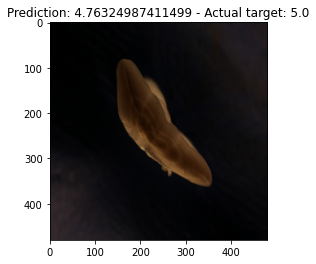

In [33]:

print(images.shape)
tmp = images[0].cpu().detach().numpy()
tmp = tmp.transpose(1,2,0)
print(tmp.shape)

plt.imshow(tmp, cmap='gray')
plt.title(f'Prediction: {PREDS_TEST[-1]} - Actual target: {labels[-1]}')
    
plt.show()

In [35]:
del model
torch.cuda.empty_cache()